# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import pearsonr
from scipy.interpolate import UnivariateSpline
import torch
import torch.nn.functional as F

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/pkn_signaling.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
# VESPA
'''x_data = pd.read_csv(os.path.join('data', 'vespa_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'vespa_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'vespa_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'vespa_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'vespa_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# DECRYPTM
'''x_data = pd.read_csv(os.path.join('data', 'decryptm_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'decryptm_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'decryptm_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'decryptm_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'decryptm_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF
'''x_data = pd.read_csv(os.path.join('data', 'egf_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF global
'''x_data = pd.read_csv(os.path.join('data', 'egf_x_global.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell_global.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug_global.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y_global.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map_global.csv'), sep=',', low_memory=False, index_col=0)'''

# EGF combined (EGF + Inhibitors)
x_data = pd.read_csv(os.path.join('data', 'egf_x_all.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'egf_xcell_all.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'egf_xdrug_all.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'egf_y_all.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'egf_nodes_sites_map_all.csv'), sep=',', low_memory=False, index_col=0)

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())
display(nodes_sites_map.head())

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


,R1,R2
Drug_CL,,
DMSO_R1,1.0,0.0
DMSO_R2,0.0,1.0
EGF_R1,1.0,0.0
EGF_R2,0.0,1.0
LY294002-EGF_R1,1.0,0.0


,DMSO,EGF,LY294002,SHP099,SL0101,UO126
O00329,0,0,1,0,0,0
P01133,0,1,0,0,0,0
P36507,0,0,0,0,0,1
P42336,0,0,1,0,0,0
P42338,0,0,1,0,0,0


,1433E:P62258:S210s,1433E:P62258:S233s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S45s,1433S:P31947:S63s,1433S:P31947:S64s,1433S:P31947:S69s,1433S:P31947:S74s,1433S:P31947:T90t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433G:P61981:S71s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S209s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S45s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Scaling down the problem to KEGG or SIGNOR
database = "KEGG"
net= net[net['sources'].str.contains(database, na=False)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map.loc[:, nodes_sites_map.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

display(nodes_sites_map_sub.head())
display(y_data.head())

,O00141,O00220,O00273,O00329,O00401,O00418,O00522,O14492,O14640,O14733,...,Q9Y4R8,Q9Y5V3,Q9Y624,Q9Y6D9,Q9Y6H5,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6R4,Q9Y6W5
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433T:P27348:S232s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1A03:P04439:S343s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1A03:P04439:S350s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433E:P62258:S210s,1433E:P62258:S233s,1433T:P27348:S232s,1A03:P04439:S343s,1A03:P04439:S350s,1A03:P04439:S352s,1A03:P04439:S356s,1A03:P04439:S359s,1C07:P10321:S353s,1C07:P10321:S357s,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.072726,-0.026762,-1.342467,-1.319392,-1.319392,-1.319392,0.823251,0.156294,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.246736,0.077428,-0.178759,-0.265259,-1.210118,-0.867945,-0.867945,-0.867945,0.398841,0.251079,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


In [5]:
# Filter nodes based on the networks input
G = nx.from_pandas_edgelist(net, source='source', target='target', create_using=nx.DiGraph())

start_nodes = list(x_drug.index)
print("Starting nodes:", start_nodes)

# Compute the reachable nodes from all start nodes.
reachable_nodes = set()
for node in start_nodes:
    if node in G:  # Only consider nodes present in the graph
        reachable_nodes.update(nx.descendants(G, node))
        reachable_nodes.add(node)
    else:
        print(f"Warning: Starting node {node} not found in graph.")

reachable_list = sorted(reachable_nodes)
print("Number of nodes connected to 'P01133':")
print(len(reachable_list))

# Filter dataframes
net = net[net['source'].isin(reachable_list) & net['target'].isin(reachable_list)]
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()

nodes_sites_map_sub = nodes_sites_map_sub.loc[:, nodes_sites_map_sub.columns.intersection(proteins_net)]
nodes_sites_map_sub = nodes_sites_map_sub[nodes_sites_map_sub.sum(axis=1) != 0]

phosphosites_keep = nodes_sites_map_sub.index
y_data = y_data.loc[:, y_data.columns.intersection(phosphosites_keep)]

display(nodes_sites_map_sub.head())
display(y_data.head())

# Plot the graph
'''plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_labels(G, pos, font_size=8)

nx.draw_networkx_nodes(G, pos,
                       nodelist=list(reachable_nodes),
                       node_color="red", node_size=500)
plt.title("Graph - Nodes reachable from 'P01133' (in red)")
plt.axis("off")
plt.show()'''

Starting nodes: ['O00329', 'P01133', 'P36507', 'P42336', 'P42338', 'Q02750', 'Q06124', 'Q15418']
Number of nodes connected to 'P01133':
523


,O00141,O00273,O00329,O00401,O00418,O14492,O14733,O14745,O14920,O14950,...,Q9Y281,Q9Y2D8,Q9Y2Z0,Q9Y490,Q9Y4H2,Q9Y5V3,Q9Y624,Q9Y6K9,Q9Y6N7,Q9Y6W5
1433T:P27348:S232s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S278s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S416s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3BP2:P78314:S444s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4EBP1:Q13541:S101s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,1433T:P27348:S232s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,4EBP1:Q13541:S65s,4EBP1:Q13541:S83s,4EBP1:Q13541:S86s,4EBP1:Q13541:T36t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


'plt.figure(figsize=(12, 12))\npos = nx.spring_layout(G)\n\nnx.draw_networkx_edges(G, pos, alpha=0.5)\nnx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)\nnx.draw_networkx_labels(G, pos, font_size=8)\n\nnx.draw_networkx_nodes(G, pos,\n                       nodelist=list(reachable_nodes),\n                       node_color="red", node_size=500)\nplt.title("Graph - Nodes reachable from \'P01133\' (in red)")\nplt.axis("off")\nplt.show()'

In [6]:
'''row_filter = "R2"

x_data = x_data[x_data.index.str.contains(row_filter)]
x_cell = x_cell[x_cell.index.str.contains(row_filter)]
#x_drug = x_drug[x_drug.index.str.contains(row_filter)]
y_data = y_data[y_data.index.str.contains(row_filter)]

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.head())'''

'row_filter = "R2"\n\nx_data = x_data[x_data.index.str.contains(row_filter)]\nx_cell = x_cell[x_cell.index.str.contains(row_filter)]\n#x_drug = x_drug[x_drug.index.str.contains(row_filter)]\ny_data = y_data[y_data.index.str.contains(row_filter)]\n\ndisplay(x_data.head())\ndisplay(x_cell.head())\ndisplay(x_drug.head())\ndisplay(y_data.head())'

In [7]:
display(net.head())

,source,target,direction,stimulation,inhibition,sources,references,0
3,P17612,Q8NER1,1,1,0,HPRD_MIMP;KEGG;MIMP;PhosphoSite_MIMP;PhosphoSi...,TRIP:12194871,NaN
4,P12931,Q8NER1,1,1,0,KEGG;MIMP;NCI-PID_ProtMapper;PhosphoSite;Phosp...,PhosphoSite:16319926;ProtMapper:16319926;ProtM...,NaN
13,Q16539,P49137,1,1,0,ACSN;BEL-Large-Corpus_ProtMapper;BioGRID;CA1;C...,ACSN:11274345;ACSN:12738796;ACSN:15187187;ACSN...,NaN
16,O60674,P19235,1,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,NaN
17,P19235,O60674,1,0,0,BioGRID;Cui2007;HPRD;KEGG-MEDICUS;SignaLink3;Wang,BioGRID:8343951;HPRD:11779507;HPRD:12441334;HP...,NaN


Let's see what the signaling network looks like:

In [8]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
3,P17612,Q8NER1,1,0
4,P12931,Q8NER1,1,0
13,Q16539,P49137,1,0
16,O60674,P19235,1,0
17,P19235,O60674,0,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [9]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
3,P17612,Q8NER1,1.0,1,0
4,P12931,Q8NER1,1.0,1,0
13,Q16539,P49137,1.0,1,0
16,O60674,P19235,1.0,1,0
17,P19235,O60674,0.1,0,0


## Define Parameters to Build and Train Model

In [10]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
             'learning_rate': 2e-3,
             'variable_lr': False}
other_params = {'lambda_dynamic': 1, 'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-7}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5, 'lambda_simplify': 0}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
module_params = {
    'use_cln': True,
    'cln_hidden_layers': {1: 64, 2: 16},  # {1: 64, 2: 16}
    'use_xssn': True,
    'xssn_hidden_layers': None,
    'use_time': False,
    'n_timepoints': 2,
    'use_phospho': True,
    'nsl_hidden_layers': {1: 16, 2:8}, #{1: 16},
    'conn_dim': 5 #5
}

hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params, **module_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [11]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map_sub,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     activation_function = 'MML',  # leaky_relu
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [12]:
mod.X_in.head()

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


In [13]:
mod.y_out.head()

,1433T:P27348:S232s,3BP2:P78314:S278s,3BP2:P78314:S416s,3BP2:P78314:S444s,4EBP1:Q13541:S101s,4EBP1:Q13541:S35s,4EBP1:Q13541:S65s,4EBP1:Q13541:S83s,4EBP1:Q13541:S86s,4EBP1:Q13541:T36t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
DMSO_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.072726,-0.413584,-0.410982,-0.199704,-1.494197,-0.657824,-2.090833,-1.479983,-2.875510,-0.985829,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002-EGF_R1_0,-0.178759,-0.268988,-0.392486,0.506518,-1.188597,-0.514818,-2.032028,-1.604272,-2.511906,-1.007109,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589


In [14]:
mod.X_cell.head()

,R1,R2
Drug_CL,,
DMSO_R1,1.0,0.0
DMSO_R2,0.0,1.0
EGF_R1,1.0,0.0
EGF_R2,0.0,1.0
LY294002-EGF_R1,1.0,0.0


## Train Model

In [15]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, train_time_points, test_time_points, missing_node_indexes, floor_idx_full, ceil_idx_full, weight = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 0.6, 'test': 0.4}, train_seed = seed, 
    verbose = True, split_by = 'time', noise_scale = 0.0)

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_time.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_time.pth'))

Time points selected for training set: [ 0 12]
i=0, l=0.98854, s=0.704, r=0.00200, v=0
i=250, l=0.11913, s=0.610, r=0.00200, v=2
i=500, l=0.09622, s=0.433, r=0.00200, v=0
i=750, l=0.09186, s=0.260, r=0.00200, v=0
i=1000, l=0.08972, s=0.196, r=0.00200, v=0
i=1250, l=0.08825, s=0.164, r=0.00200, v=0
i=1500, l=0.08639, s=0.240, r=0.00200, v=1
i=1750, l=0.08415, s=0.138, r=0.00200, v=0
i=2000, l=0.08241, s=0.110, r=0.00200, v=1
i=2250, l=0.08100, s=0.158, r=0.00200, v=0
i=2500, l=0.07995, s=0.313, r=0.00200, v=1
i=2750, l=0.07947, s=0.252, r=0.00200, v=0
i=3000, l=0.07849, s=0.259, r=0.00200, v=0
i=3250, l=0.07781, s=0.282, r=0.00200, v=1
i=3500, l=0.07723, s=0.263, r=0.00200, v=1
i=3750, l=0.07675, s=0.296, r=0.00200, v=0
i=4000, l=0.07644, s=0.270, r=0.00200, v=0
i=4250, l=0.07587, s=0.291, r=0.00200, v=0
i=4500, l=0.07602, s=0.305, r=0.00200, v=0
i=4750, l=0.07523, s=0.263, r=0.00200, v=0
Training ran in: 15 min 39.48 sec


## Predict Using Model

In [16]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_time.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_time.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_628\230434054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [17]:
X_in = mod.df_to_tensor(mod.X_in)
X_cell = mod.df_to_tensor(mod.X_cell)
mod.eval()
Y_hat, Y_full, Y_fullFull, Y_fullprotein  = mod(X_in, X_cell, missing_node_indexes)

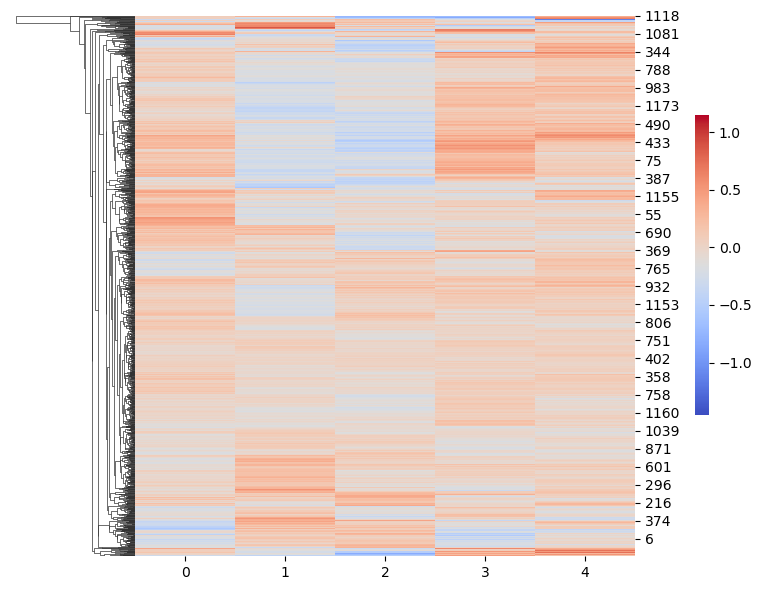

In [18]:
embedding = mod.nodes_sites_layer.site_embedding
embedding_np = embedding.detach().cpu().numpy()
sns.clustermap(
    embedding_np, 
    cmap='coolwarm', 
    figsize=(7, 6), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

## Visualize

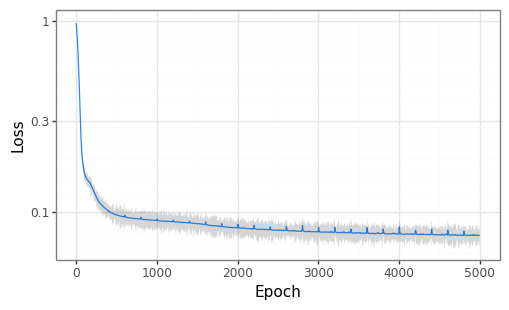

In [19]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
#p1A += p9.geom_hline(yintercept = mean_loss.item(), linetype="dashed", color="black")
p1A.draw()

As well as how the learning rate was adjusted across training:

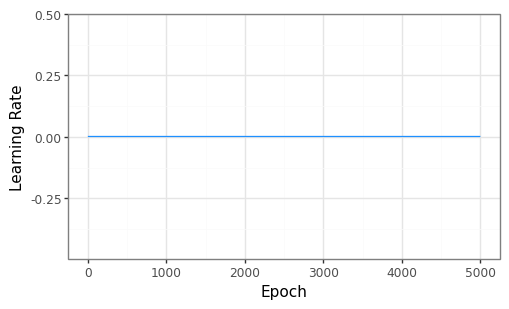

In [20]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

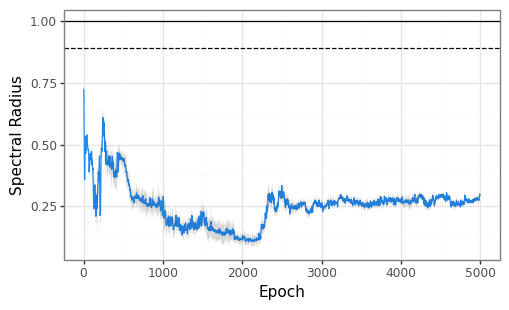

In [21]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Plot how the time mapping is changing across epochs

In [22]:
'''# Prepare the data for plotting
epochs = np.array(range(len(stats['mapping'])))
mapping_data = []

last_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping

for epoch, mapping in enumerate(stats['mapping']):
    for time_point, value in enumerate(mapping):
        time_point_name = last_iteration_mapping[time_point]
        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})

mapping_df = pd.DataFrame(mapping_data)
mapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)

# Real time points
real_time_points = train_time_points
real_time_df = pd.DataFrame({'Real Time Points': real_time_points})

# Generate a color palette dictionary
color_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))

# Plot using plotnine
p = (
    p9.ggplot(mapping_df, p9.aes(x='Epoch', y='Value', color='Time Point')) +
    p9.geom_line(size=1) +
    p9.geom_hline(p9.aes(yintercept='Real Time Points'), data=real_time_df, color='black', linetype='dashed') +
    p9.scale_color_manual(values=color_palette) +
    p9.labs(x='Epoch', y='Time Mapping', color='Time Point') +
    p9.theme_classic()
)

p.draw()'''

"# Prepare the data for plotting\nepochs = np.array(range(len(stats['mapping'])))\nmapping_data = []\n\nlast_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping\n\nfor epoch, mapping in enumerate(stats['mapping']):\n    for time_point, value in enumerate(mapping):\n        time_point_name = last_iteration_mapping[time_point]\n        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})\n\nmapping_df = pd.DataFrame(mapping_data)\nmapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)\n\n# Real time points\nreal_time_points = train_time_points\nreal_time_df = pd.DataFrame({'Real Time Points': real_time_points})\n\n# Generate a color palette dictionary\ncolor_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))\n\n# Plot using plotnine\np = (\n

Interpolate the mapping for the intermediate testing time points using spline interpolation.

In [23]:
'''def fit_spline_time_mapping(train_times: np.array, train_mapping: np.array, smoothing: float = 1.0):
    """
    Fit a UnivariateSpline to the training mapping data.
    
    Parameters:
      train_times: np.array of shape (N,) containing training time points.
      train_mapping: np.array of shape (N,) containing learned mapping indices.
      smoothing: smoothing factor (larger values yield smoother spline and help prevent overfitting).
    
    Returns:
      spline_model: Fitted UnivariateSpline object.
    """
    spline_model = UnivariateSpline(train_times, train_mapping, s=smoothing)
    return spline_model


train_mapping = floor_idx_full + weight
train_mapping = train_mapping[0, :, 0].detach().cpu()

# Convert training and test times to numpy arrays if needed:
train_times_arr = np.array(train_time_points)
train_mapping_arr = np.array(train_mapping)  # corresponding mapping indices from training
test_times_arr  = np.array(test_time_points)  # unseen test time points

# Fit the spline
smoothing_factor = 0.01  # higher = smoother
spline_model = fit_spline_time_mapping(train_times_arr, train_mapping_arr, smoothing=smoothing_factor)

# Predict mapping indices for the test time points.
predicted_test_mapping = spline_model(test_times_arr)
predicted_test_mapping_tensor = torch.tensor(predicted_test_mapping, dtype=torch.float32)
floor_idx_test = torch.floor(predicted_test_mapping_tensor).long()  # shape (K,)
ceil_idx_test = torch.clamp(floor_idx_test + 1, max=bionet_params['max_steps']-1)  # shape (K,)
weight_test = (predicted_test_mapping_tensor - floor_idx_test.float()).view(1, -1, 1)  # shape (1, K, 1)
    
time_dense = np.linspace(train_times_arr.min(), train_times_arr.max(), 200)
dense_mapping = spline_model(time_dense)

df_points = pd.DataFrame({
    'Time': train_times_arr,
    'Mapping': train_mapping_arr
})
df_test = pd.DataFrame({
    'Time': test_times_arr,
    'Mapping': predicted_test_mapping
})
df_spline = pd.DataFrame({
    'Time': time_dense,
    'Mapping': dense_mapping
})

# Plot the to evaluate
p_spline = (p9.ggplot() +
            p9.geom_point(data=df_points, mapping=p9.aes(x='Time', y='Mapping'),
                          color='darkblue', shape='o', size=3) +
            p9.geom_line(data=df_spline, mapping=p9.aes(x='Time', y='Mapping'),
                         color='#d8031c', size=1) +
            p9.geom_point(data=df_test, mapping=p9.aes(x='Time', y='Mapping'),
                          shape='s', color='darkblue', size=3) +
            p9.labs(title='Spline Fit for Training Time Mapping',
                    x='Training Time',
                    y='Mapping Index') +
            p9.theme_classic())

p_spline.draw()'''

'def fit_spline_time_mapping(train_times: np.array, train_mapping: np.array, smoothing: float = 1.0):\n    """\n    Fit a UnivariateSpline to the training mapping data.\n    \n    Parameters:\n      train_times: np.array of shape (N,) containing training time points.\n      train_mapping: np.array of shape (N,) containing learned mapping indices.\n      smoothing: smoothing factor (larger values yield smoother spline and help prevent overfitting).\n    \n    Returns:\n      spline_model: Fitted UnivariateSpline object.\n    """\n    spline_model = UnivariateSpline(train_times, train_mapping, s=smoothing)\n    return spline_model\n\n\ntrain_mapping = floor_idx_full + weight\ntrain_mapping = train_mapping[0, :, 0].detach().cpu()\n\n# Convert training and test times to numpy arrays if needed:\ntrain_times_arr = np.array(train_time_points)\ntrain_mapping_arr = np.array(train_mapping)  # corresponding mapping indices from training\ntest_times_arr  = np.array(test_time_points)  # unseen test

### Model Benchmarking

Evaluate model. Plot correlation for each site. Plot example site trajectory across cell lines and drugs.

torch.Size([40, 1379]) torch.Size([40, 1379])


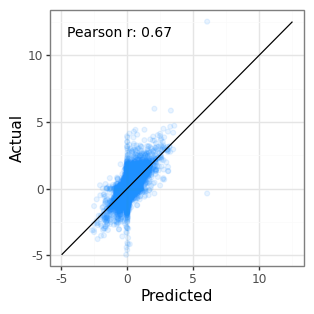

In [24]:
y_index = mod.y_out.index.tolist()
y_actual = y_train

Y_hat_train, Y_full_train, Y_fullFull_train, Y_fullprotein = mod(X_train, X_cell_train, missing_node_indexes)
unique_time_points = [0, 12]
Y_subsampled = Y_fullFull_train[:, unique_time_points, :]
Y_subsampled_ctr = Y_subsampled[:, 0:1, :]
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(2, len(X_train_index), mod.y_out.shape[1])
y_actual_ctr = y_actual[0:1, :, :]
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

In [ ]:


def soft_index(Y: torch.Tensor, indices: torch.Tensor):
    """
    Differentiably sample hidden states from Y using linear interpolation.

    Parameters
    ----------
    Y : torch.Tensor
        Tensor of shape (batch, L, feat), where L is the total number of time steps.
    indices : torch.Tensor
        Continuous indices of shape (K,) in the range [0, L-1]. These represent the time steps to sample.

    Returns
    -------
    Y_selected : torch.Tensor
        Tensor of shape (batch, K, feat) containing interpolated values at the given indices.
    """
    batch, L, feat = Y.shape
    K = indices.shape[0]
    
    # Compute the floor and ceiling indices for each desired index.
    floor_idx = torch.floor(indices).long()             # Shape: (K,)
    ceil_idx = torch.clamp(floor_idx + 1, max=L - 1)       # Shape: (K,)
    
    # Compute linear interpolation weight: weight is the fractional part.
    weight = (indices - floor_idx.float()).view(1, K, 1)   # Shape: (1, K, 1)
    
    # Expand indices to match dimensions for gathering
    floor_idx = floor_idx.view(1, K, 1).expand(batch, K, feat)
    ceil_idx = ceil_idx.view(1, K, 1).expand(batch, K, feat)
    
    # Gather the corresponding values from Y along the time (second) dimension.
    Y_floor = torch.gather(Y, 1, floor_idx)  # (batch, K, feat)
    Y_ceil  = torch.gather(Y, 1, ceil_idx)   # (batch, K, feat)
    
    # Perform linear interpolation between the floor and ceiling values.
    Y_selected = (1 - weight) * Y_floor + weight * Y_ceil
    
    return Y_selected

def optimize_test_mapping(Y_full: torch.Tensor, 
                          test_data: torch.Tensor, 
                          training_times: list[float], 
                          training_mapping: list[float], 
                          test_times: list[float],
                          num_epochs: int = 1000, 
                          lr: float = 1e-3,
                          noise_level: float = 0.0,
                          seed: int = 42):
    """
    Optimize a set of test mapping indices so that, when used with soft indexing,
    they best match test_data. Uses softplus increments and monotonicity constraints.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Always run on CPU to avoid CUDA backward issues
    device = torch.device("cpu")
    Y_full = Y_full.to(device)
    test_data = test_data.to(device)
    
    T = len(test_times)
    dtype = Y_full.dtype

    # Construct monotonic interval constraints
    training_times_arr = np.array(training_times, dtype=float)
    training_mapping_arr = np.array(training_mapping, dtype=float)
    lower_bounds = []
    upper_bounds = []

    for t in test_times:
        if t <= training_times_arr[0]:
            lb, ub = 0, 0
        elif t >= training_times_arr[-1]:
            lb, ub = training_mapping_arr[-1]+1, training_mapping_arr[-1]+1
        else:
            idx = np.searchsorted(training_times_arr, t) - 1
            lb = training_mapping_arr[idx]
            ub = training_mapping_arr[idx+1]
        lower_bounds.append(lb)
        upper_bounds.append(ub)

    print("Lower bounds:", lower_bounds)
    print("Upper bounds:", upper_bounds)
    
    lower_bounds = torch.tensor(lower_bounds, dtype=dtype, device=device)
    upper_bounds = torch.tensor(upper_bounds, dtype=dtype, device=device)

    # Optimization variable (raw increments)
    raw = torch.randn(T, dtype=dtype, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([raw], lr=lr)
    
    final_lr = lr * 0.01
    lr_list = []
    noise_list = []
    for epoch in range(num_epochs):
        # Variable learning rate
        frac = epoch / (num_epochs - 1)  # Ranges 0 → 1 across epochs 
        current_lr = lr * ((final_lr / lr) ** frac)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Forward/Backward pass
        optimizer.zero_grad()

        # Softplus ensures increments are positive
        increments = F.softplus(raw)
        mapping_candidate = lower_bounds + torch.cumsum(increments, dim=0)
        mapping_candidate = torch.min(mapping_candidate, upper_bounds)

        # Soft index predicted values
        Y_pred = soft_index(Y_full, mapping_candidate)

        # Mask for valid entries
        mask = ~torch.isnan(test_data)
        Y_pred_masked = Y_pred.masked_fill(~mask, 0.0)
        test_data_masked = test_data.masked_fill(~mask, 0.0)

        loss = F.mse_loss(Y_pred_masked, test_data_masked)
        
        loss.backward(retain_graph=True)
        
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, LR={current_lr:.6f}, Mapping = {mapping_candidate.detach().numpy()}")
            #print(f"  raw.grad = {raw.grad.detach().cpu().numpy()}")
        
        current_noise = noise_level * (current_lr**2)
        for param in optimizer.param_groups[0]["params"]:
            if noise_level > 0.0 and param.grad is not None:
                param.grad.data += torch.randn_like(param.grad) * current_noise
        optimizer.step()

        current_lr = optimizer.param_groups[0]['lr']
        lr_list.append(current_lr)
        noise_list.append(current_noise)
    return mapping_candidate.detach(), Y_pred.detach(), lr_list, noise_list



Lower bounds: [0.0, 0.0, 0.0]
Upper bounds: [12.0, 12.0, 12.0]
Epoch 0: Loss = 0.0360, LR=0.100000, Mapping = [0.12506942 2.2613003  2.984004  ]
Epoch 100: Loss = 0.0349, LR=0.063067, Mapping = [0.05053465 2.8027272  3.4854815 ]
Epoch 200: Loss = 0.0347, LR=0.039774, Mapping = [0.0450198 2.7529352 3.3399405]
Epoch 300: Loss = 0.0347, LR=0.025084, Mapping = [0.04900985 2.7517364  3.2853498 ]
Epoch 400: Loss = 0.0347, LR=0.015820, Mapping = [0.04988482 2.7768881  3.2726107 ]
Epoch 500: Loss = 0.0347, LR=0.009977, Mapping = [0.05162405 2.7775254  3.2611604 ]
Epoch 600: Loss = 0.0347, LR=0.006292, Mapping = [0.05282382 2.780897   3.257968  ]
Epoch 700: Loss = 0.0347, LR=0.003968, Mapping = [0.05370655 2.7841256  3.2571313 ]
Epoch 800: Loss = 0.0347, LR=0.002503, Mapping = [0.05431975 2.7853186  3.255643  ]
Epoch 900: Loss = 0.0347, LR=0.001578, Mapping = [0.05475134 2.7862356  3.2548108 ]
Epoch 999: Loss = 0.0347, LR=0.001000, Mapping = [0.05504748 2.786779   3.2542207 ]
Final mapping: ten

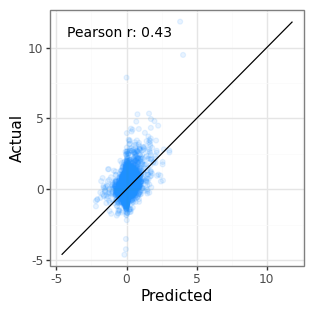

In [33]:
y_index = mod.y_out.index.tolist()
y_actual = y_test

y_actual = y_actual.reshape(3, len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual.permute(1, 0, 2)

Y_hat_test, Y_full_test, Y_fullFull_test, Y_fullprotein = mod(X_test, X_cell_test, missing_node_indexes)
unique_time_points = [2, 4, 8]
Y_subsampled = Y_fullFull_test[:, unique_time_points, :]

mapping, Y_subsampled, _, _ = optimize_test_mapping(Y_fullFull_test, y_actual, [0, 12], [0, 12], unique_time_points, num_epochs = 1000, lr = 1e-1, noise_level = 1, seed=seed)
print('Final mapping:', mapping)
Y_subsampled = soft_index(Y_fullFull, mapping.to(device))
Y_subsampled = Y_subsampled.to(device)
Y_subsampled = Y_subsampled - Y_subsampled_ctr #Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)

y_actual = y_actual.permute(1, 0, 2)
y_actual = y_actual - y_actual_ctr #y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 27 rows containing missing values.


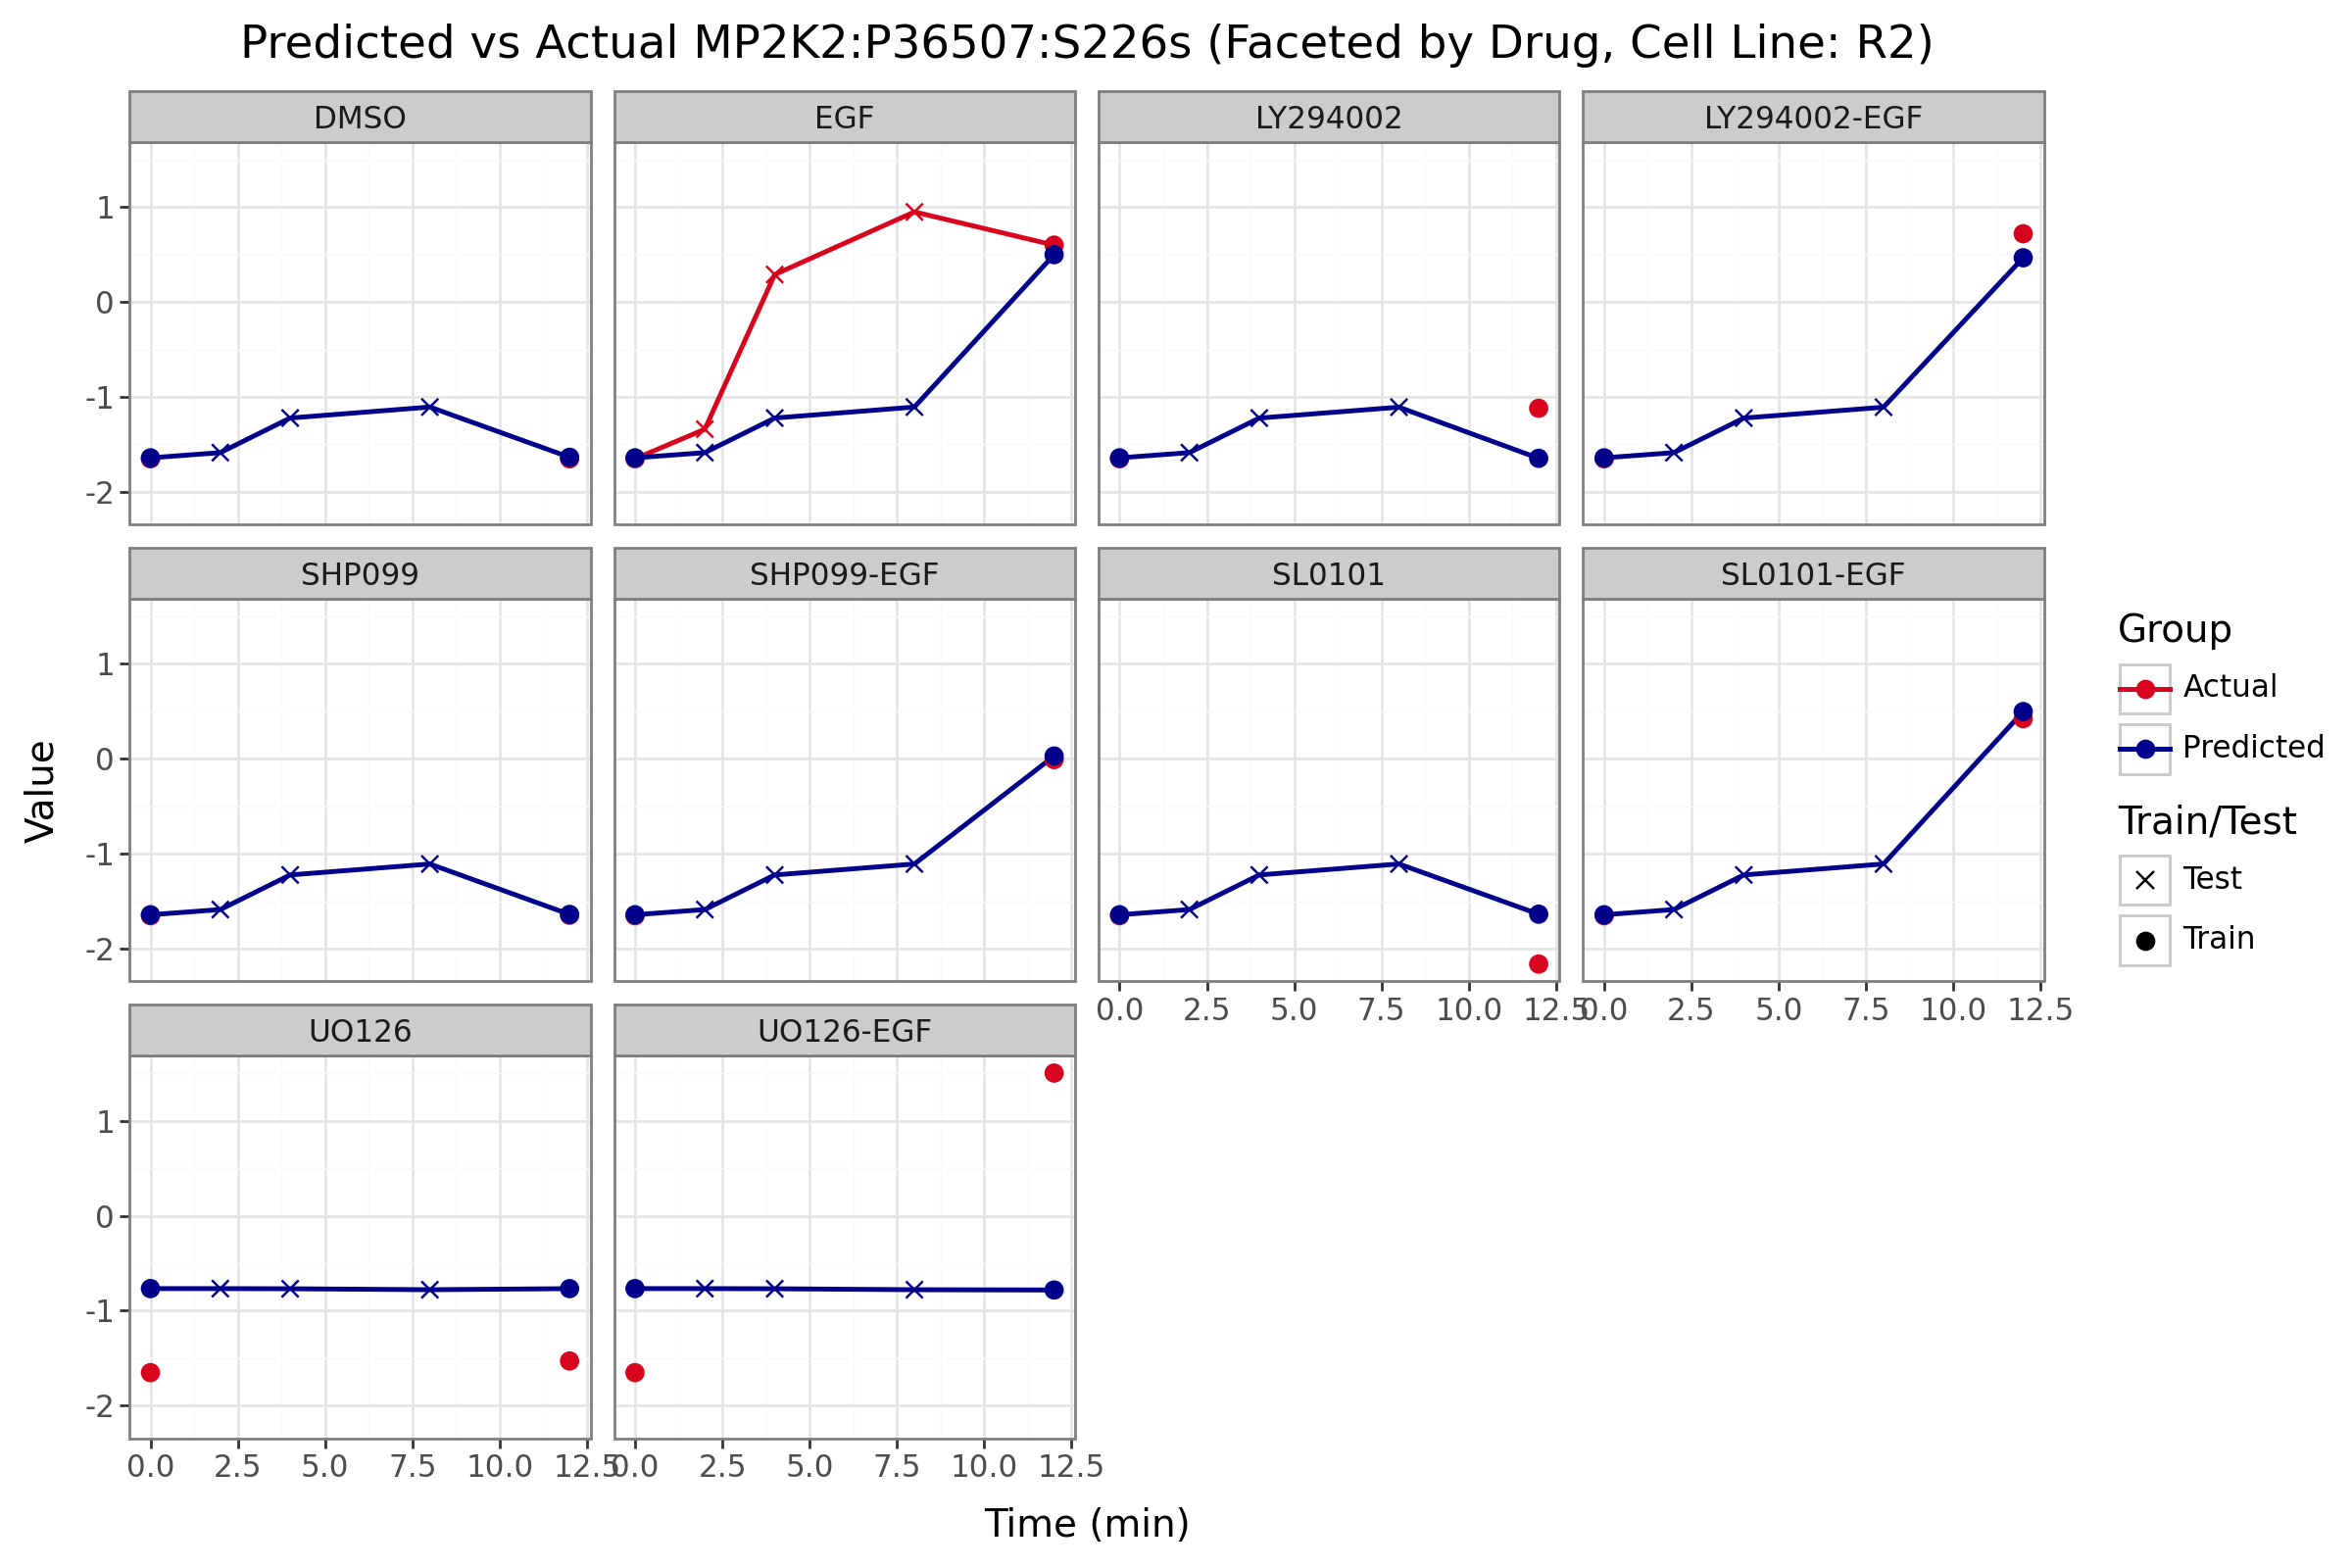

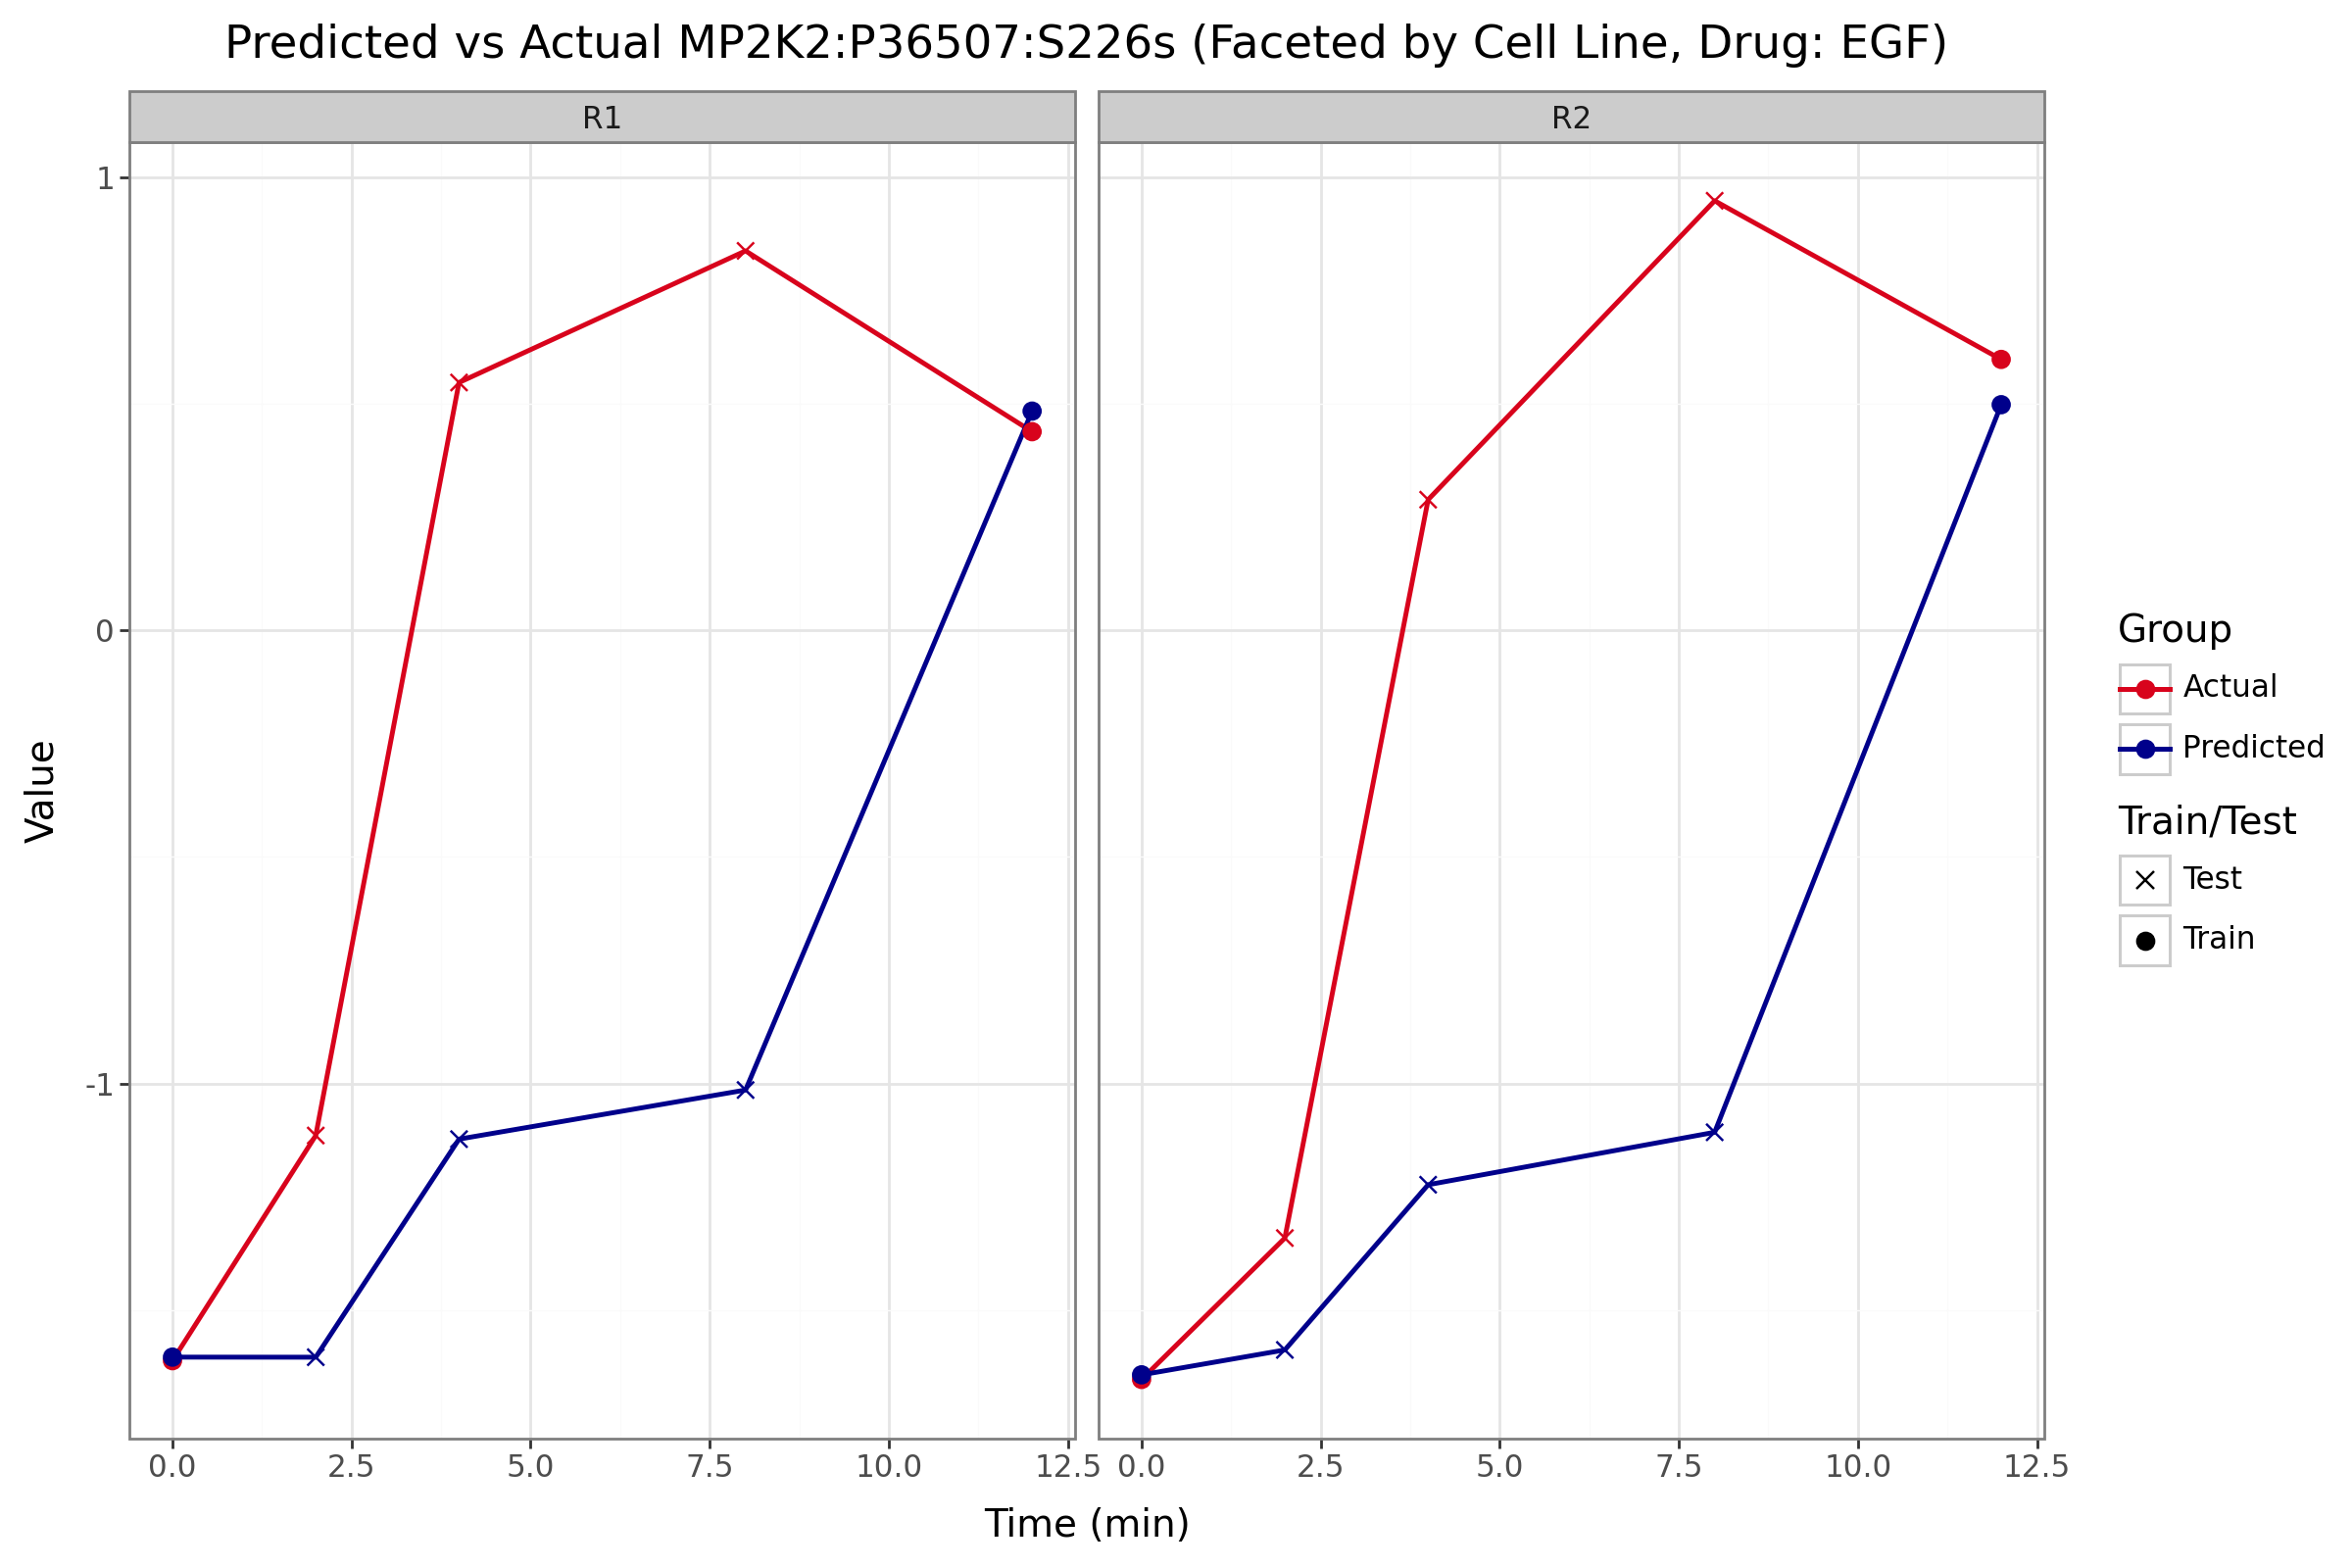

In [37]:
drug_input = "EGF"
cl_input = "R2"
phosphosite_input = "MP2K2:P36507:S226s"  # MP2K2:P36507:S226s, BRAF:P15056:T753t, BRAF:P15056:S365s, MK01:P28482:T185t, MAPK2:P49137:T334t, SHC1:P29353:S139s, SHC1:P29353:S41s, SHC1:P29353:S453s, SHC1:P29353:Y349y, SHC1:P29353:Y350y, SHC1:P29353:Y427y, PTN11:Q06124:S142s, PTN11:Q06124:S562s, PTN11:Q06124:Y546y, PTN11:Q06124:Y62y, GAB1:Q13480:S209s, GAB1:Q13480:S266s, GAB1:Q13480:S274s, GAB1:Q13480:S355s, GAB1:Q13480:S401s, GAB1:Q13480:S419s, GAB1:Q13480:S500s, GAB1:Q13480:S551s, GAB1:Q13480:S634s, GAB1:Q13480:S650s, GAB1:Q13480:S651s, GAB1:Q13480:T199t, GAB1:Q13480:T211t, GAB1:Q13480:T365t, GAB1:Q13480:T377t, GAB1:Q13480:T390t, GAB1:Q13480:T503t, GAB1:Q13480:T638t, GAB1:Q13480:Y259y, GAB1:Q13480:Y285y, GAB1:Q13480:Y406y, GAB1:Q13480:Y447y, GAB1:Q13480:Y627y, GAB1:Q13480:Y659y
x_values = [0, 2, 4, 8, 12]  #list(range(150))  [0, 2 , 5, 12, 28, 64, 149]  [0, 3, 6, 9, 12, 15, 18, 21]  [0, 1, 2, 3, 5, 10, 20, 50]
y_out = mod.df_to_tensor(mod.y_out)

train_timepoints = [0, 12]
Y_train = Y_fullFull[:, train_timepoints, :]
Y_test = soft_index(Y_fullFull, mapping.to(device))
Y_all = torch.cat([Y_train, Y_test], dim=1)  # (batch, N_train+N_test, features)
all_times = np.concatenate([np.array(train_timepoints), np.array(mapping)])  # (N_train+N_test,)
sorted_idx = np.argsort(all_times)
Y_plot = Y_all[:, sorted_idx, :]

y_out = mod.df_to_tensor(mod.y_out)
#Y_plot = subsample_Y(Y_fullFull, floor_idx, ceil_idx, weight)
Y_plot = Y_plot.permute(1, 0, 2)
Y_plot = torch.flatten(Y_plot, start_dim=0, end_dim=1)

# Prepare the Y_actual
y_actual = y_data.reset_index().rename(columns={"index": "Drug_CL_Time"})
y_actual[['Drug', 'CL', 'Time']] = y_actual['Drug_CL_Time'].str.split('_', expand=True)
y_actual['Time'] = y_actual['Time'].astype(int)

df_cell = y_actual[y_actual['CL'] == cl_input].copy()
df_drug = y_actual[y_actual['Drug'] == drug_input].copy()

df_cell['Group'] = df_cell['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug['Group'] = df_drug['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})

# Sort the DataFrames by time for clarity.
df_cell = df_cell.sort_values(by=['Drug', 'CL', 'Time'])
df_drug = df_drug.sort_values(by=['Drug', 'CL', 'Time'])

cell_conditions = df_cell['Drug_CL_Time'].tolist()
drug_conditions = df_drug['Drug_CL_Time'].tolist()
cell_indices = [y_data.index.get_loc(cond) for cond in cell_conditions]
drug_indices = [y_data.index.get_loc(cond) for cond in drug_conditions]

phosphosite_idx = y_data.columns.get_loc(phosphosite_input)

# For the cell subset:
Y_cell_site = Y_plot[cell_indices, phosphosite_idx]
Drug, CL, Time = zip(*[cond.split('_') for cond in cell_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_cell_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_cell_site.detach().cpu().numpy(),
    'Drug': Drug
})

# For the drug subset:
Y_drug_site = Y_plot[drug_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in drug_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_drug_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_drug_site.detach().cpu().numpy(),
    'CL': CL
})

# Create the actual data
df_cell = df_cell[df_cell['Drug_CL_Time'].isin(cell_conditions)]
df_cell["Train/Test"] = df_cell["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_cell = df_cell[['Time', phosphosite_input, 'Drug', "Train/Test"]]
df_cell = df_cell.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_cell["Group"] = "Actual"

df_drug = df_drug[df_drug['Drug_CL_Time'].isin(drug_conditions)]
df_drug["Train/Test"] = df_drug["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug = df_drug[['Time', phosphosite_input, 'CL', "Train/Test"]]
df_drug = df_drug.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_drug["Group"] = "Actual"

df_cell_pred['Train/Test'] = df_cell['Train/Test'].reset_index(drop=True)
df_cell_pred['Group'] = "Predicted"
df_drug_pred['Train/Test'] = df_drug['Train/Test'].reset_index(drop=True)
df_drug_pred['Group'] = "Predicted"

df_cell_plot = pd.concat([df_cell, df_cell_pred], axis=0)
df_drug_plot = pd.concat([df_drug, df_drug_pred], axis=0)

# Plot A: Facet by Drug (for the specified cell line)
plot_A = (
    p9.ggplot(df_cell_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test', group='Group'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ Drug')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Drug, Cell Line: {cl_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_A.show()

# Plot B: Facet by Cell Line (for the specified drug)
plot_B = (
    p9.ggplot(df_drug_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test', group='Group'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ CL')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 'x'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Cell Line, Drug: {drug_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_B.show()